In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.append('/content/drive/My Drive/coarsen')
sys.path.append('/content/drive/My Drive/coarsen/data')
sys.path.append('/content/drive/My Drive/coarsen/coarsening.py')

In [0]:
%load_ext autoreload
%autoreload 2
%aimport coarsening

In [4]:
import os,sys,inspect
import os
import joblib
import tensorflow as tf
import numpy as np
import h5py
import scipy.sparse.linalg as la
import scipy.sparse as sp
import scipy
import time
import pickle

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

import scipy.io as sio
import process_data
import sklearn.metrics
import sklearn.neighbors
import scipy.sparse
import scipy.sparse.linalg
import scipy.spatial.distance
import skimage.measure
from sklearn.preprocessing import normalize
np.seterr(divide='ignore', invalid='ignore')


import matplotlib.cm

In [0]:
def laplacian(W, normalized=True):
    """
    Return the Laplacian of the weigth matrix.
    W: input adjacency or weight matrix.
    
    """

    # Degree matrix.
    d = W.sum(axis=0)

    # Laplacian matrix.
    if not normalized:
        D = scipy.sparse.diags(d.A.squeeze(), 0)
        L = D - W
    else:
        d += np.spacing(np.array(0, W.dtype))
        d = 1 / np.sqrt(d)
        D = scipy.sparse.diags(d.A.squeeze(), 0)
        I = scipy.sparse.identity(d.size, dtype=W.dtype)
        L = I - D * W * D

    # assert np.abs(L - L.T).mean() < 1e-9
    assert type(L) is scipy.sparse.csr.csr_matrix
    return L
 


def coarsen(A, levels, normalized):
    graphs, parents = coarsening.metis(A, levels) #Coarsen a graph multiple times using Graclus variation of the METIS algorithm. 
                                                  #Basically, we randomly sort the nodes, we iterate on them and we decided to group each node
                                                  #with the neighbor having highest w_ij * 1/(\sum_k w_ik) + w_ij * 1/(\sum_k w_kj) 
                                                  #i.e. highest sum of probabilities to randomly walk from i to j and from j to i.
                                                  #We thus favour strong connections (i.e. the ones with high weight wrt all the others for both nodes) 
                                                  #in the choice of the neighbor of each node.
                    
                                                  #Construction is done a priori, so we have one graph for all the samples!
                    
                                                  #graphs = list of spare adjacency matrices (it contains in position 
                                                  #          0 the original graph)
                                                  #parents = list of numpy arrays (every array in position i contains 
                                                  #           the mapping from graph i to graph i+1, i.e. the idx of
                                                  #           node i in the coarsed graph -> that is, the idx of its cluster) 
    perms = coarsening.compute_perm(parents) #Return a list of indices to reorder the adjacency and data matrices so
                                             #that two consecutive nodes correspond to neighbors that should be collapsed
                                             #to produce the coarsed version of the graph.
                                             #Fake nodes are appended for each node which is not grouped with anybody else
    laplacians = []
    for i,A in enumerate(graphs):
        M, M = A.shape

        # We remove self-connections created by metis.
        A = A.tocoo()
        A.setdiag(0)

        if i < levels: #if we have to pool the graph 
            A = coarsening.perm_adjacency(A, perms[i]) #matrix A is here extended with the fakes nodes
                                                       #in order to do an efficient pooling operation
                                                       #in tensorflow as it was a 1D pooling

        A = A.tocsr()
        A.eliminate_zeros()
        Mnew, Mnew = A.shape
        print('Layer {0}: M_{0} = |V| = {1} nodes ({2} added), |E| = {3} edges'.format(i, Mnew, Mnew-M, A.nnz//2))

        L = laplacian(A, normalized)
        laplacians.append(L)

    return laplacians, parents, perms[0] if len(perms) > 0 else None

  


  
#Cayley filter defination:
def cayley_operator(L, r, scale, coefficients): # r is the order of the polynomial
    s = np.linalg.norm(L, 2)
    h = 2.0*scale/s
    N = L.shape[0]
    A = (h*L - 1j*np.identity(N)) @ np.linalg.inv(h*L + 1j*np.identity(N))
    AA = np.eye(A.shape[0])
    res = np.eye(A.shape[0])*coefficients[0]
    for k in range(r):
        res = res + 2.0* coefficients[k+1] * (AA @ A).real
        AA = AA @ A
    return res.real

  
  
def poly_operator(L, r, coefficients):
    AA = np.eye(L.shape[0])
    res = np.eye(L.shape[0])*coefficients[0]
    for k in range(r):
        res = res + coefficients[k+1] * (AA @ L)
        AA = AA @ L
    return res

  
  
def interpolate(feature):
    N, M = feature.shape
    new_feature = np.zeros((2*N, M))
    for i in range(N):
        new_feature[2*i, :] = feature[i,:]
        new_feature[2*i + 1, :] = feature[i,:]
    return new_feature

  
  
def pooling(feature, perm, dim_graph):
    feature_after_pool = np.zeros((feature.shape[0]//2, feature.shape[1]))
    for i in range(len(feature)//2):
        if perm[2*i] >=dim_graph and perm[2*i+1] >=dim_graph:
            print('THERE IS ERROR WHEN COARENING')
        if perm[2*i] >=dim_graph:
            feature_after_pool[i, :] = feature[2*i+1,:]
        elif perm[2*i+1] >=dim_graph:
            feature_after_pool[i, :] = feature[2*i,:]     
        else:
            feature_after_pool[i, :] = (feature[2*i,:] + feature[2*i+1,:])/2.0
    return feature_after_pool
  
  

# Sampling operator
def construct_S(perm, m, n): # m is the dimension of the coarsened graph, n is the original dimension
    S = np.zeros((m,n))
    for i in range(m):
      if perm[2*i] >=n and perm[2*i+1] >=n:
        print('THERE IS ERROR WHEN COARENING')
      if perm[2*i] >=n:
        S[i,perm[2*i+1]] = 1.0
      elif perm[2*i+1] >=n:
        S[i,perm[2*i]] = 1.0    
      else:
        S[i,perm[2*i]] = 1.0/np.sqrt(2)
        S[i,perm[2*i+1]] = 1.0/np.sqrt(2)
    return S
                
    
    
def convert_map(perm):
    new_perm = np.arange(len(perm))
    new_perm = new_perm[perm]
    new_perm = np.argsort(new_perm)
    return new_perm


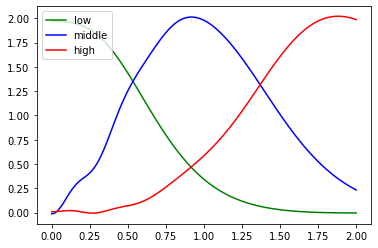

In [6]:
def cayley(lamb, c, h, r):
    complex_value = 0.5 * c[0] * np.ones(len(lamb))
    for i in range(1, r+1):
        complex_value = complex_value + c[i]*((h*lamb -1j)**i)*((h*lamb + 1j)**(-i))
    return 2.0 * (complex_value.real)

coefficients_low = np.array([ 0.762957  , -0.55845029,  0.16243145,  0.04000212, -0.04137109,
                          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                          0.        ,  0.        ,  0.        ])*0.985 * 0.98
coefficients_middle = np.array([ 0.72875482, -0.14645678, -0.44402514,  0.13537618,  0.12523632,
                                0.00815884, -0.03310949, -0.01980383, -0.00557673,  0.01227825,
                                -0.00673004,  0.01079311, -0.00618034])*1.05*0.98

coefficients_high = np.array([ 0.52028883,  0.213328  , -0.2321755 , -0.30423973, -0.11923577,
                              0.04332396,  0.10535769,  0.07566094,  0.02054968, -0.01731303,
                              -0.02321388, -0.00983169, -0.00594752])*0.96

lamb = np.linspace(0,2, 100)

fig = plt.figure()
ax1 = fig.add_subplot(111)

r = 12
h = 1.0

ax1.plot(lamb, cayley(lamb, coefficients_low, h, r), c='g', label='low')
ax1.plot(lamb, cayley(lamb, coefficients_middle, h, r), c='b', label='middle')
ax1.plot(lamb, cayley(lamb, coefficients_high, h, r),c='r', label='high')
plt.legend(loc='upper left');
plt.show()

In [7]:
#dataset loading

"""A, X, Y, train_idx, val_idx, test_idx = process_data.load_data("citeseer")
X = process_data.preprocess_features(X)
A = A.astype(float)
X = np.array(X)"""

'A, X, Y, train_idx, val_idx, test_idx = process_data.load_data("citeseer")\nX = process_data.preprocess_features(X)\nA = A.astype(float)\nX = np.array(X)'

In [0]:
#####################################
### IMPORT BUNNY ADJACENCY MATRIX ###
#####################################

A = sp.load_npz('/content/drive/My Drive/coarsen/Bunny_Adj.npz')

In [0]:
#############################################
### EIGEN-DECOMPOSITION OF ORIGINAL GRAPH ###
#############################################

L = laplacian(A, True)
L = L.toarray()

w, v = np.linalg.eig(L)
w = w.real # take only the real part of the eigenvalues
v = v.real # take only the real part of the eigenvectors

index = np.argsort(w) # index is the vector of the indexes of w but ordered in increasing order wrt the eigenvalues
w = w[index] # reorder eigenvalues
v = v[:,index] # reorder eigenvectors

In [10]:
########################
### GRAPH COARSENING ###
########################

np.random.seed(0)

dim_graph = A.shape[0]

nonormal_laplacians, parents, perm = coarsen(A, 1, True)

new_perm = convert_map(perm)

S = construct_S(perm, nonormal_laplacians[1].shape[0], dim_graph)

L_coarse = S @ L @ S.T

Layer 0: M_0 = |V| = 2658 nodes (155 added), |E| = 7473 edges
Layer 1: M_1 = |V| = 1329 nodes (0 added), |E| = 3962 edges


In [0]:
poly_coefficients_low = np.array([1.0, 0.0, -0.25])
poly_coefficients_middle = np.array([0.5, 1.0, -0.5])
poly_coefficients_high = np.array([0.0, 1.0, -0.25])

poly_operator_low = poly_operator(L, 2, poly_coefficients_low)
poly_operator_middle = poly_operator(L, 2, poly_coefficients_middle)
poly_operator_high = poly_operator(L, 2, poly_coefficients_high)
poly_operator_coarse_low = poly_operator(L_coarse, 2, poly_coefficients_low)
poly_operator_coarse_middle = poly_operator(L_coarse, 2, poly_coefficients_middle)
poly_operator_coarse_high = poly_operator(L_coarse, 2, poly_coefficients_high)

In [0]:
features = v[:,0:dim_graph:10]
features = normalize(features, axis=0, norm='l2')
features_coarse = S @ features
features_coarse_after_laplacian = L_coarse @ features_coarse
features_after_laplacian = L @ features
features_after_laplacian_coarse = S @ features_after_laplacian
right_term = np.linalg.norm(features_after_laplacian_coarse - features_coarse_after_laplacian, ord = 2, axis = 0)

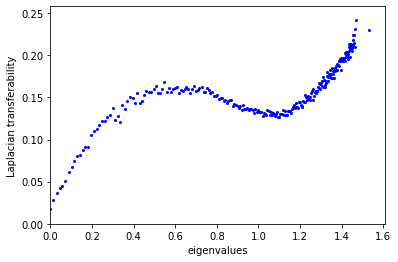

In [13]:
plt.scatter(w[0:dim_graph:10], right_term, s=4,  color="blue")
plt.xlabel('eigenvalues')
plt.ylabel('Laplacian transferability')
plt.axis([0, None, 0, None])
plt.savefig("/content/drive/My Drive/coarsen/images/laplacian_transferability_for_coarsen.pdf", format='pdf')

In [0]:
features_low = poly_operator_low @ features
features_middle = poly_operator_middle @ features
features_high = poly_operator_high @ features
features_low_coarse = S @ features_low
features_middle_coarse = S @ features_middle
features_high_coarse = S @ features_high

features_coarse_low = poly_operator_coarse_low @ features_coarse
features_coarse_middle = poly_operator_coarse_middle @ features_coarse
features_coarse_high = poly_operator_coarse_high @ features_coarse

left_low = np.linalg.norm(features_coarse_low - features_low_coarse, ord = 2, axis = 0)
left_middle = np.linalg.norm(features_coarse_middle - features_middle_coarse, ord = 2, axis = 0)
left_high = np.linalg.norm(features_coarse_high - features_high_coarse, ord = 2, axis = 0)

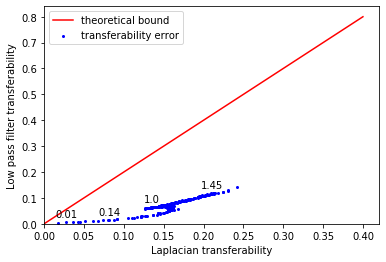

In [15]:
plt.scatter(right_term, left_low, s=4, color='blue', label="transferability error")
plt.plot(np.linspace(0, 0.4, 100), 2.0*np.linspace(0, 0.4, 100), 'y', color='red', label="theoretical bound")
plt.legend(loc="upper left")

labels = [ round(x, 2) for x in w[0:dim_graph:10] ]
plt.legend(loc="upper left")
for i in [1, 10, 100, 240]:
     plt.annotate(labels[i], # this is the text
                   (right_term[i],left_low[i]), # this is the point to label
                   textcoords="offset points", # how to position the text
                   xytext=(0,5.0), # distance from text to points (x,y)
                   ha='center', color='black') # horizontal alignment can be left, right or center


plt.xlabel('Laplacian transferability')
plt.ylabel('Low pass filter transferability')
plt.axis([0, None, 0, None])
plt.savefig("/content/drive/My Drive/coarsen/images/low_filter_transferability_for_coarsen.pdf", format='pdf')

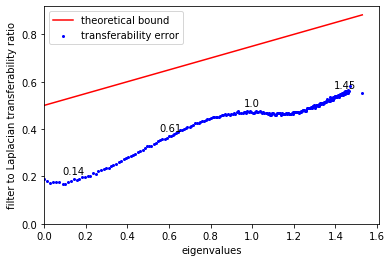

In [16]:
def bound_low(x):
  return x/4.0 + 0.5

chosened_eigns = w[0:dim_graph:10]
plt.scatter(w[0:dim_graph:10], left_low/right_term,s=4, color='blue', label="transferability error")

plt.plot(w[0:dim_graph:10], bound_low(w[0:dim_graph:10]),color='red', label="theoretical bound")
plt.legend(loc="upper left")

for i in [10, 50, 100, 240]:
     plt.annotate(labels[i], # this is the text
                   (chosened_eigns[i],left_low[i]/right_term[i]), # this is the point to label
                   textcoords="offset points", # how to position the text
                   xytext=(0,5.0), # distance from text to points (x,y)
                   ha='center', color='black') # horizontal alignment can be left, right or center

plt.xlabel('eigenvalues')
plt.ylabel('filter to Laplacian transferability ratio')
plt.axis([0, None, 0, None])
plt.savefig("/content/drive/My Drive/coarsen/images/ratioVseigenvalue_for_low_pass.pdf", format='pdf')